# File and libraries

In [8]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_final"

# DSLabs functions

In [9]:
%run "scripts/dslabs_functions.py"


# Data functions

In [10]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [11]:

test_data=True
# test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    # data=data.sample(frac=0.05, replace=False)
    # test=test.sample(frac=0.05, replace=False)
    # train=train.sample(frac=0.05, replace=False)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # larger sample 10%
    # data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)

 
target='returning_user'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7433 entries, 0 to 7432
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   device_category                  7433 non-null   float64
 1   device_mobile_model_name         7433 non-null   float64
 2   device_operating_system          7433 non-null   float64
 3   device_operating_system_version  7433 non-null   float64
 4   device_language                  7433 non-null   float64
 5   device_web_info_browser          7433 non-null   float64
 6   device_web_info_browser_version  7433 non-null   float64
 7   geo_region                       7433 non-null   float64
 8   geo_city                         7433 non-null   float64
 9   traffic_source_medium            7433 non-null   float64
 10  traffic_source_source            7433 non-null   float64
 11  engagement_time_msec             7433 non-null   float64
 12  month                    

# Distribution Check

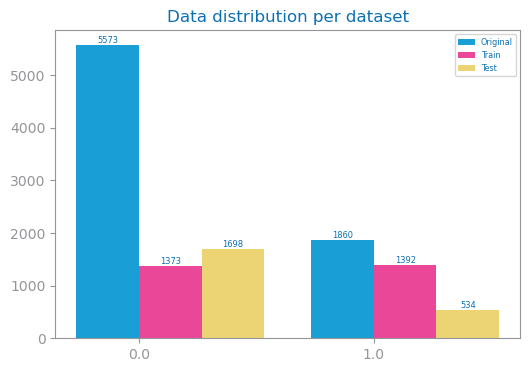

In [12]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [13]:
if test_data==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=2765 Test#=2232
Labels=[0.0, 1.0]


## recall evaluation

KNN best with k=15 and chebyshev


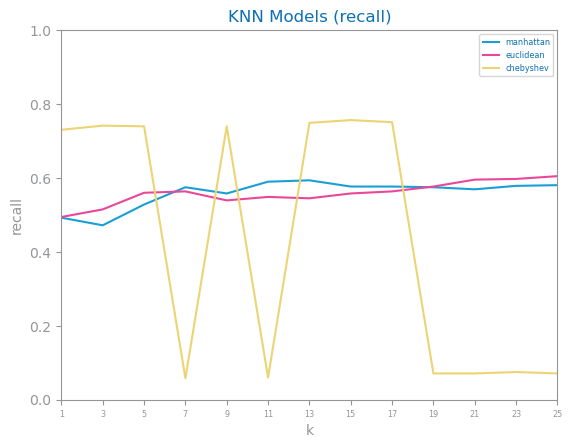

In [14]:
if evaluate==True:

    best_model_recall, recall_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric='recall')
    savefig(f'images/{file_tag}_knn_recall_study.png')
    show()

## evaluate precision

KNN best with k=23 and chebyshev


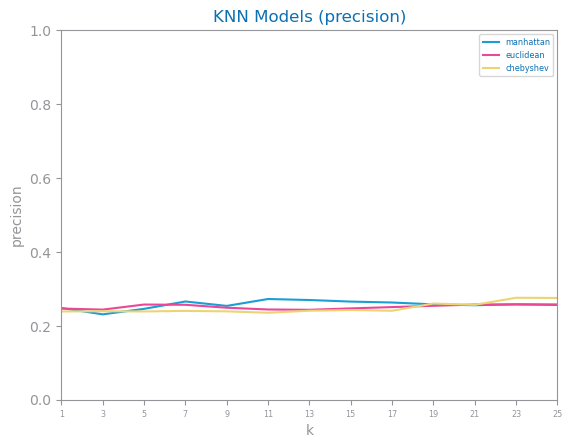

In [15]:
if evaluate==True:

    best_model_prec, prec_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric='precision')
    savefig(f'images/{file_tag}_knn_precision_study.png')
    show()

## evaluate accuracy

KNN best with k=25 and chebyshev


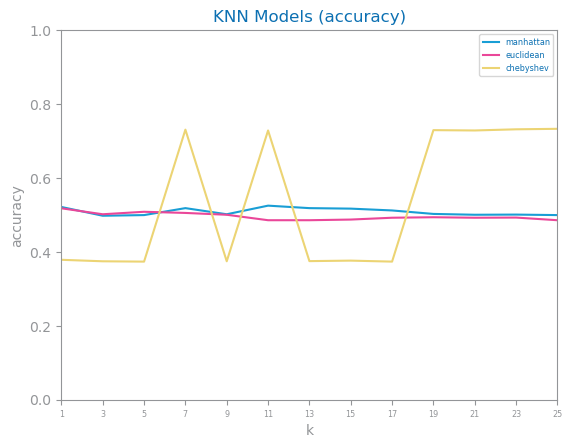

In [16]:
if evaluate==True:

    best_model_fl, fl_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric='accuracy')
    savefig(f'images/{file_tag}_knn_accuracy_study.png')
    show()

## Evaluate for best model

KNN best with k=23 and chebyshev


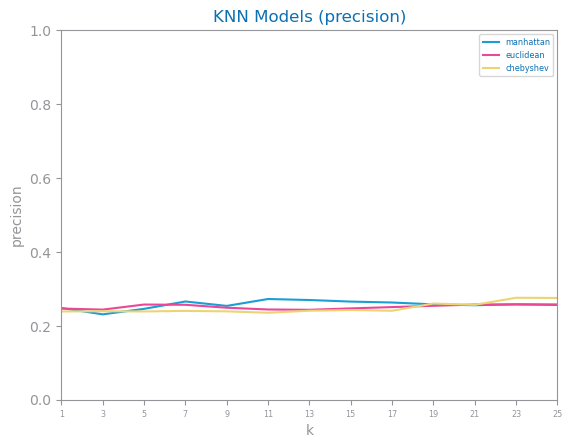

In [17]:
if evaluate==True:

    figure()

    eval_metric = 'precision'

    best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
    savefig(f'images/{file_tag}_knn_{eval_metric}_study.png')
    show()

# Best Model Performance

<Figure size 640x480 with 0 Axes>

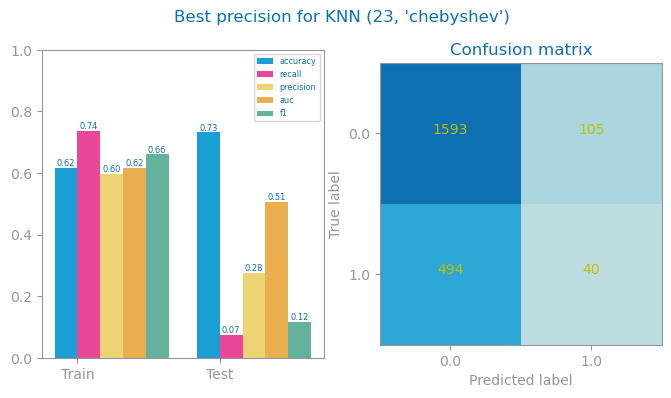

In [18]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

# Overfitting

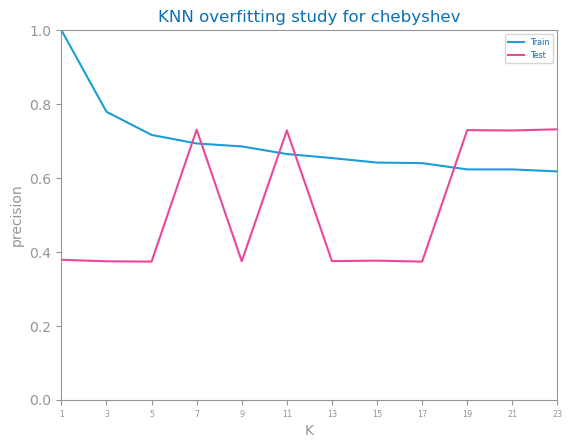

In [19]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_overfitting.png")
show()

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
